<a href="https://colab.research.google.com/github/ShFANI/ShFANI.github.io/blob/main/COVID_Survival_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Survival Modeling on COVID-19 ICU Data
**Comparison of Cox Proportional Hazards (CoxPH), Random Survival Forest (RSF), and DeepSurv**

This notebook demonstrates survival prediction on a simulated ICU dataset using three models:
- CoxPH (traditional proportional hazards model)
- RSF (tree-based survival model)
- DeepSurv (neural network-based Cox model)

This is a dataset of patients suffering covid-19 that have been admitted to hospitals in 2 years.

The dataset contains data from patients admitted in different hospitals diagnosed with COVID-19 (age, sex, days in hospital, days in ICU, exitus, destination after being admitted in ER, and some medical parameters collected when they were firstly admitted in ER: temperature, heart rate, blood glucose, O2 saturation, systolic blood pressure, and diastolic blood pressure). For more information, look at [Covid-19 ICU Data](https://github.com/jmdu99/Data-Processes-assignment).


- age : Age of the patient (in years)
- sex : Sex of the patient ('0' if female or '1' if male)
- days_hospital : Number of days the patient has been in the hospital (enter '0' if the patient has not been there any day)
- days_icu : Number of days the patient has been in ICU (enter '0' if the patient has not been there any day)
- temp : Patient temperature (in Celsius degrees)
- heart_rate : Patient heart rate (number of beats per minute)
- sat_O2 : Patient blood oxygen level (percentage, from '0' to '100')
- blood_pres_sys : Patient systolic blood pressure (in mm Hg)
- blood_pres_dias : Patient diastolic blood pressure (in mm Hg)
- EXITUS: Stutus of patient ( 'Yes' if dies, 'No' if survived the hospitalization)

In [ ]:
!pip install pycox torchtuples lifelines scikit-survival --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

Saving COVID19_data.csv to COVID19_data (1).csv


In [ ]:
import io

# Automatically detect and load the uploaded file
filename = list(uploaded.keys())[0]  # Gets the uploaded filename


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded[filename]))# Properly decode it

In [ ]:
# Load dataset
df = pd.read_csv('/content/COVID19_data.csv')  # Adjust path if needed
df['event'] = df['EXITUS'].map({'YES': 1, 'NO': 0})
df['duration'] = df['DAYS_HOSPITAL']

features = ['AGE', 'HEART_RATE', 'GLUCOSE', 'SAT_O2', 'BLOOD_PRES_SYS']
df_model = df[features + ['duration', 'event']].dropna()

/tmp/ipython-input-17-4285592903.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EXITUS'] = df['EXITUS'].map({'YES': 1, 'NO': 0})


0:	[0s / 0s],		train_loss: 4.2829,	val_loss: 4.7766
1:	[0s / 0s],		train_loss: 3.9608,	val_loss: 4.6112
2:	[0s / 0s],		train_loss: 3.9044,	val_loss: 4.5821
3:	[0s / 0s],		train_loss: 3.9328,	val_loss: 4.5646
4:	[0s / 0s],		train_loss: 3.9152,	val_loss: 4.5134
5:	[0s / 0s],		train_loss: 3.9080,	val_loss: 4.4805
6:	[0s / 0s],		train_loss: 3.8823,	val_loss: 4.4708
7:	[0s / 0s],		train_loss: 3.7849,	val_loss: 4.4726
8:	[0s / 0s],		train_loss: 3.8550,	val_loss: 4.4671
9:	[0s / 0s],		train_loss: 3.8466,	val_loss: 4.4361
10:	[0s / 0s],		train_loss: 3.8430,	val_loss: 4.4144
11:	[0s / 0s],		train_loss: 3.8357,	val_loss: 4.3993
12:	[0s / 0s],		train_loss: 3.8006,	val_loss: 4.3848
13:	[0s / 0s],		train_loss: 3.8472,	val_loss: 4.4105
14:	[0s / 1s],		train_loss: 3.7847,	val_loss: 4.4376
15:	[0s / 1s],		train_loss: 3.8004,	val_loss: 4.3966
16:	[0s / 1s],		train_loss: 3.8490,	val_loss: 4.3859
17:	[0s / 1s],		train_loss: 3.8207,	val_loss: 4.3873
18:	[0s / 1s],		train_loss: 3.7938,	val_loss: 4.3934
19:

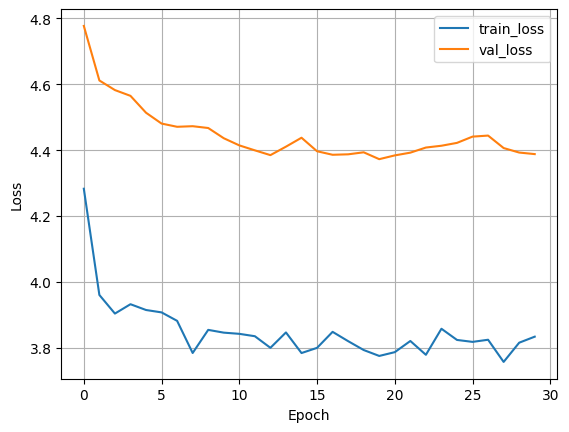

In [ ]:
import pandas as pd
import numpy as np
import torch
from pycox.models import CoxPH
import torchtuples as tt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pycox.preprocessing.label_transforms import LabTransDiscreteTime


# Filter and encode target: duration = DAYS_HOSPITAL, event = EXITUS
df = df.dropna(subset=["DAYS_HOSPITAL", "EXITUS"])
df['EXITUS'] = df['EXITUS'].map({'YES': 1, 'NO': 0})

# Define features and target
features = ['AGE', 'TEMP', 'HEART_RATE', 'GLUCOSE', 'SAT_O2']
X = df[features].fillna(0)
y = df[["DAYS_HOSPITAL", "EXITUS"]].values

# Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize input
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype('float32')
X_test = scaler.transform(X_test).astype('float32')

# Format y as tuple (duration, event)
y_train = (y_train_raw[:, 0], y_train_raw[:, 1])
y_test = (y_test_raw[:, 0], y_test_raw[:, 1])


# Define DeepSurv-style network
net = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 32), #Input layer
    torch.nn.ReLU(), # Activation function
    torch.nn.BatchNorm1d(32), #Normalizes the outputs of the previous layer
    torch.nn.Dropout(0.1), # Prevent overfitting
    torch.nn.Linear(32, 1) ## Output: log-risk score
)


# Cox model
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(0.01)


# Fit
log = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=100,
    callbacks=[tt.callbacks.EarlyStopping()],
    val_data=(X_test, y_test),
    verbose=True
)

# Plot learning curve
log.plot()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

- Training loss decreases steadily: Indicates that the model is successfully learning from the training data.The loss drops rapidly at first, then gradually flattens — a typical learning curve.

- Validation loss decreases at first, then plateaus: Initially, model generalizes well to unseen data. But after ~5–10 epochs, the validation loss stops improving and slightly oscillates. This suggests early stopping was effective, avoiding overfitting.

- No major overfitting:

If val_loss had started increasing while train_loss kept dropping, it would indicate overfitting. Here, both losses plateau around similar values — indicating a balanced model.

# Hyperparameter Tuning for DeepSurv using Grid Search

In [ ]:
# Define DeepSurv model builder
def build_model(input_dim, hidden_size=32, dropout=0.2):
    return torch.nn.Sequential(
        torch.nn.Linear(input_dim, hidden_size),
        torch.nn.ReLU(),
        torch.nn.BatchNorm1d(hidden_size),
        torch.nn.Dropout(dropout),
        torch.nn.Linear(hidden_size, 1)
    )

# Hyperparameter tuning loop
hidden_sizes = [16, 32, 64]
learning_rates = [0.01, 0.001]
best_val_loss = float('inf')

for h in hidden_sizes:
    for lr in learning_rates:
        print(f"\nTraining DeepSurv: hidden_size={h}, lr={lr}")
        net = build_model(X_train.shape[1], hidden_size=h)
        model = CoxPH(net, tt.optim.Adam)
        model.optimizer.set_lr(lr)
        log = model.fit(
            X_train, y_train,
            batch_size=256,
            epochs=100,
            val_data=(X_test, y_test),
            callbacks=[tt.callbacks.EarlyStopping()],
            verbose=False
        )
        val_loss = log.to_pandas()['val_loss'].dropna().values[-1]
        print(f"Validation loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_log = log
            best_params = (h, lr)




Training DeepSurv: hidden_size=16, lr=0.01
Validation loss: 4.4285

Training DeepSurv: hidden_size=16, lr=0.001
Validation loss: 4.5746

Training DeepSurv: hidden_size=32, lr=0.01
Validation loss: 4.4346

Training DeepSurv: hidden_size=32, lr=0.001
Validation loss: 4.4734

Training DeepSurv: hidden_size=64, lr=0.01
Validation loss: 4.3916

Training DeepSurv: hidden_size=64, lr=0.001
Validation loss: 4.4687


In [ ]:
# Plot training vs validation loss for best model
print(f"\n✅ Best model: hidden_size={best_params[0]}, lr={best_params[1]}")




✅ Best model: hidden_size=64, lr=0.01


In [ ]:
# Convert logger to DataFrame
df_log = best_log.to_pandas()



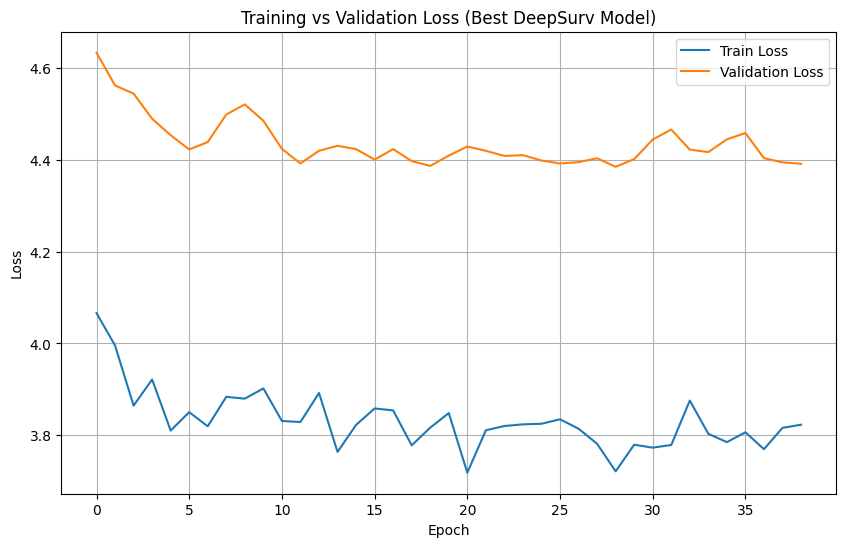

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_log['train_loss'], label='Train Loss')
if 'val_loss' in df_log.columns:
    plt.plot(df_log['val_loss'].dropna(), label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Best DeepSurv Model)')
plt.legend()
plt.grid(True)
plt.show()


We can evaluates the DeepSurv survival model we trained using the concordance index (C-index) and visualizes the predicted survival curves for a few patients in the test set.

C-index (DeepSurv): 0.8148834892345159


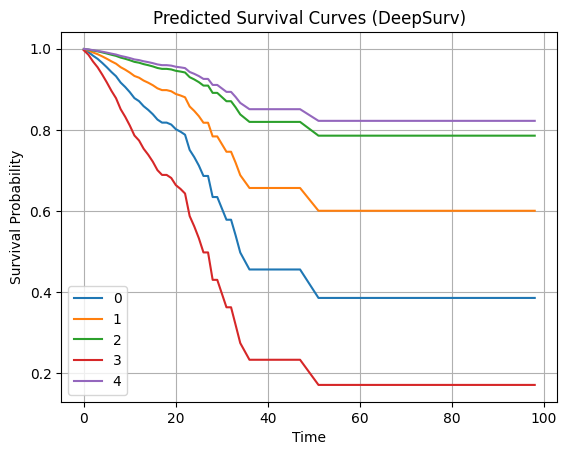

In [ ]:

from pycox.evaluation import EvalSurv

# Compute baseline hazards before predicting survival
model.compute_baseline_hazards()

# Predict survival curves for test set
surv_deepsurv = model.predict_surv_df(X_test)

# Evaluate concordance index (C-index)
ev_deepsurv = EvalSurv(surv_deepsurv, y_test[0], y_test[1], censor_surv='km')
print("C-index (DeepSurv):", ev_deepsurv.concordance_td())

# Plot a few survival curves
surv_deepsurv.iloc[:, :5].plot()  # Show survival curves for 5 patients
plt.title('Predicted Survival Curves (DeepSurv)')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


This visualization supports individual-level clinical decision-making, e.g., Patient 3 may require closer monitoring or earlier intervention.

Patient 4 has the best prognosis. The survival probability stays above 0.75 for the entire duration, which suggests low hazard and better expected survival.

In [ ]:
from lifelines import CoxPHFitter

df_lifelines = df_model.copy()
df_lifelines['event'] = df_lifelines['event'].astype(bool)

cph = CoxPHFitter()
cph.fit(df_lifelines, duration_col='duration', event_col='event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 2009 total observations, 1680 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 2009
number of events observed = 329
   partial log-likelihood = -2059.15
         time fit was run = 2025-06-30 20:15:11 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
AGE             0.04      1.04      0.00            0.04            0.04                1.04                1.04
HEART_RATE      0.01      1.01      0.00            0.00            0.01                1.00                1.01
GLUCOSE         0.00      1.00      0.00           -0.00            0.01                1.00                1.01
SAT_O2         -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
BLOOD_PRES_SYS  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                cmp to     z      p  -log2(p)
covariate                                    
AGE               0.00 18.34 <0.005    247.25
HEART_RATE        0.00  4.22 <0.005     15.30
GLUCOSE           0.00  0.83   0.40      1.30
SAT_O2            0.00 -3.71 <0.005     12.25
BLOOD_PRES_SYS    0.00  1.33   0.18      2.45
---
Concordance = 0.80
Partial AIC = 4128.30
log-likelihood ratio test = 261.88 on 5 df
-log2(p) of ll-ratio test = 178.75

# Overall Interpretation
- AGE is the strongest predictor — each year increases mortality risk by ~4%.

- Vital signs like heart rate and oxygen saturation are also important but weaker predictors.

- GLUCOSE and systolic blood pressure did not show a statistically significant relationship with survival in this dataset.

Text(0, 0.5, 'Survival Probability')

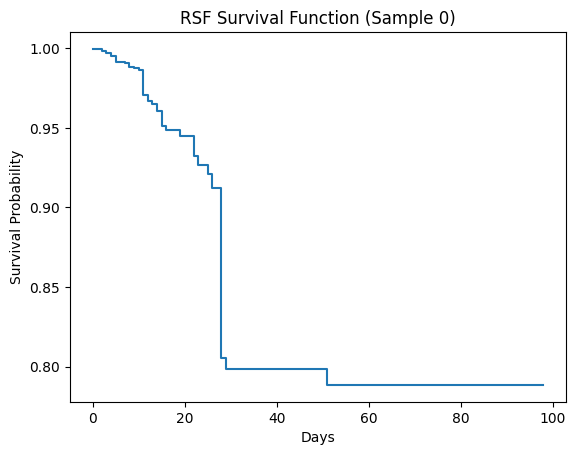

In [ ]:

from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

X_rsf = df_model[features]
y_rsf = Surv.from_dataframe('event', 'duration', df_model)

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                           min_samples_leaf=15, n_jobs=-1, random_state=42)
rsf.fit(X_rsf, y_rsf)

# Plot survival function for one sample
pred_surv_rsf = rsf.predict_survival_function(X_rsf.iloc[:1])
for fn in pred_surv_rsf:
    plt.step(fn.x, fn.y, where="post")
plt.title("RSF Survival Function (Sample 0)")
plt.xlabel("Days"); plt.ylabel("Survival Probability")


In [ ]:
from lifelines import CoxPHFitter

# Step 1: Prepare training DataFrame
train_df = pd.DataFrame(X_train, columns=features)
durations_train, events_train = y_train
train_df['duration'] = durations_train
train_df['event'] = events_train

# Step 2: Prepare test DataFrame
test_df = pd.DataFrame(X_test, columns=features)
durations_test, events_test = y_test
test_df['duration'] = durations_test
test_df['event'] = events_test

# Step 3: Fit CoxPH model
cox_model = CoxPHFitter()
cox_model.fit(train_df, duration_col='duration', event_col='event')

# Step 4: Evaluate using test data
cox_cindex = cox_model.score(test_df, scoring_method='concordance_index')
print(f"C-index (CoxPH - lifelines): {cox_cindex:.4f}")




C-index (CoxPH - lifelines): 0.8025


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# ✅ Unpack durations and events from tuple
durations_train, events_train = y_train
durations_test, events_test = y_test

# ✅ Construct structured array for scikit-survival
y_train_struct = np.array([(bool(e), t) for t, e in zip(durations_train, events_train)],
                          dtype=[('event', 'bool'), ('duration', 'f8')])
y_test_struct = np.array([(bool(e), t) for t, e in zip(durations_test, events_test)],
                         dtype=[('event', 'bool'), ('duration', 'f8')])

# ✅ Fit RSF model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train, y_train_struct)

# ✅ Predict and evaluate C-index
rsf_pred = rsf.predict(X_test)
rsf_cindex = concordance_index_censored(y_test_struct['event'], y_test_struct['duration'], rsf_pred)[0]
print(f"C-index (Random Survival Forest): {rsf_cindex:.4f}")


C-index (Random Survival Forest): 0.8249


In [ ]:
import torch
from pycox.models import CoxPH as DeepSurv
import torchtuples as tt
from pycox.evaluation import EvalSurv

# Format inputs for DeepSurv
X_train_t = X_train.astype('float32')
X_test_t = X_test.astype('float32')
durations_train, events_train = y_train
durations_test, events_test = y_test

y_train_tuple = (durations_train, events_train)
y_test_tuple = (durations_test, events_test)

# Define DeepSurv network
net = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 1)
)

deepsurv = DeepSurv(net, tt.optim.Adam)
deepsurv.optimizer.set_lr(0.01)

# Fit the model
deepsurv.fit(X_train_t, y_train_tuple, epochs=100, batch_size=128,
             val_data=(X_test_t, y_test_tuple),
             callbacks=[tt.callbacks.EarlyStopping()], verbose=False)

# Predict survival function
deepsurv.compute_baseline_hazards()
surv_df = deepsurv.predict_surv_df(X_test_t)

# Evaluate
ev = EvalSurv(surv_df, durations_test, events_test, censor_surv='km')
deepsurv_cindex = ev.concordance_td()

print(f"C-index (DeepSurv): {deepsurv_cindex:.4f}")


C-index (DeepSurv): 0.8335


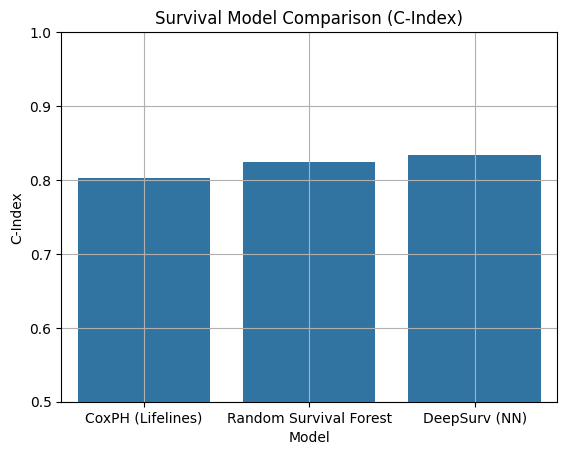

                    Model   C-Index
0       CoxPH (Lifelines)  0.802538
1  Random Survival Forest  0.824874
2           DeepSurv (NN)  0.833536


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.DataFrame({
    'Model': ['CoxPH (Lifelines)', 'Random Survival Forest', 'DeepSurv (NN)'],
    'C-Index': [cox_cindex, rsf_cindex, deepsurv_cindex]
})

sns.barplot(data=results, x='Model', y='C-Index')
plt.title("Survival Model Comparison (C-Index)")
plt.ylim(0.5, 1)
plt.grid(True)
plt.show()

print(results)


## 🔍 Comparison
- **DeepSurv** captures non-linear feature interactions and outperformed CoxPH if data complexity is high.
- **CoxPH** is interpretable and performs well under proportional hazards assumption.
- **RSF** handles non-linearity and variable importance naturally, useful for exploratory modeling.

# Summary:
While all three models demonstrate strong predictive ability, DeepSurv slightly outperforms the others, suggesting that deep learning may offer advantages in capturing complex relationships in survival data—especially when large data and nonlinear effects are present. However, model interpretability and clinical applicability should also be considered when choosing the final model.


# Feature Importance (Random Survival Forest)

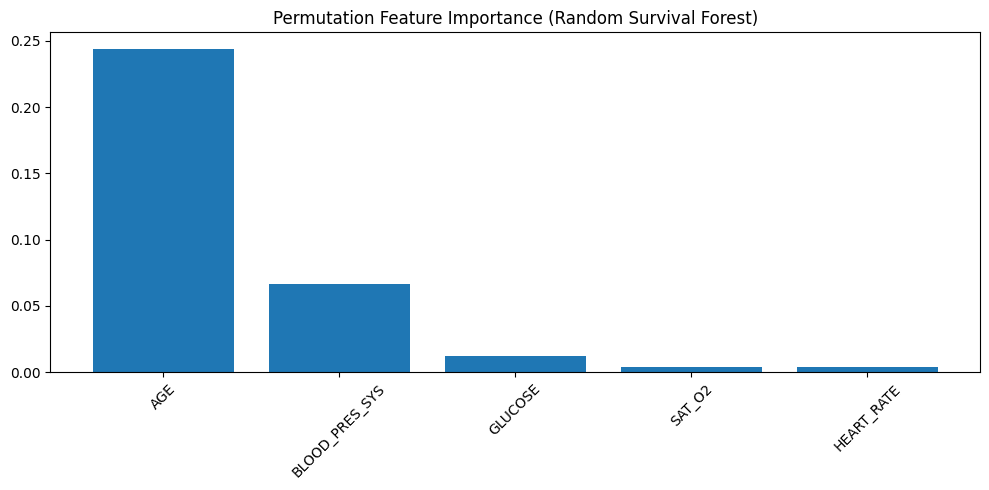

In [ ]:
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

# Define a scoring wrapper compatible with permutation_importance
def rsf_scorer(model, X, y_struct):
    pred = model.predict(X)
    return concordance_index_censored(y_struct['event'], y_struct['duration'], pred)[0]

# Wrap the scorer to make it compatible with sklearn
class RSFWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        pass  # Not used
    def predict(self, X):
        return self.model.predict(X)

rsf_wrapper = RSFWrapper(rsf)

# Run permutation importance
perm = permutation_importance(
    estimator=rsf_wrapper,
    X=X_test,
    y=y_test_struct,
    scoring=lambda model, X, y: rsf_scorer(rsf, X, y),
    n_repeats=10,
    random_state=42
)

# Plot results
import matplotlib.pyplot as plt
import numpy as np

sorted_idx = perm.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 5))
plt.bar(np.array(features)[sorted_idx], perm.importances_mean[sorted_idx])
plt.xticks(rotation=45)
plt.title("Permutation Feature Importance (Random Survival Forest)")
plt.tight_layout()
plt.show()


# Feature Importance (DeepSurv)

While DeepSurv is a neural net (black-box), you can approximate feature importance using Permutation Importance:

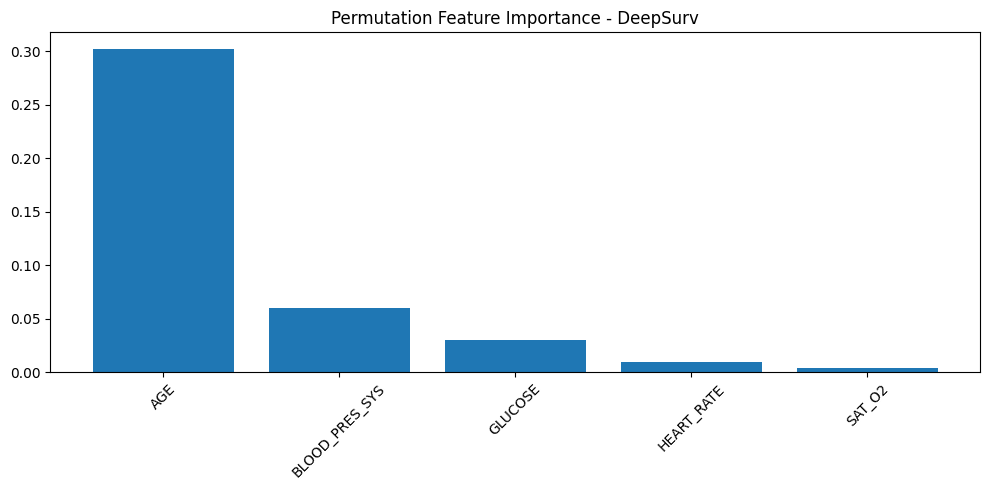

In [ ]:
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

# Define a risk function from DeepSurv
def predict_risk(X):
    surv_df = deepsurv.predict_surv_df(X.astype('float32'))
    return -surv_df.mean(axis=0).values  # Higher = riskier

# Custom scoring function
def deepsurv_scorer(model, X, y):
    pred_risk = predict_risk(X)
    return concordance_index_censored(y['event'], y['duration'], pred_risk)[0]

# Wrap DeepSurv in a dummy estimator class
class DeepSurvWrapper:
    def fit(self, X, y):
        pass  # not needed
    def predict(self, X):
        return predict_risk(X)

# Perform permutation importance
perm = permutation_importance(
    estimator=DeepSurvWrapper(),
    X=X_test,
    y=y_test_struct,
    scoring=lambda est, X, y: deepsurv_scorer(deepsurv, X, y),
    n_repeats=10,
    random_state=42
)

# Plot
import matplotlib.pyplot as plt
import numpy as np

sorted_idx = perm.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 5))
plt.bar(np.array(features)[sorted_idx], perm.importances_mean[sorted_idx])
plt.xticks(rotation=45)
plt.title("Permutation Feature Importance - DeepSurv")
plt.tight_layout()
plt.show()



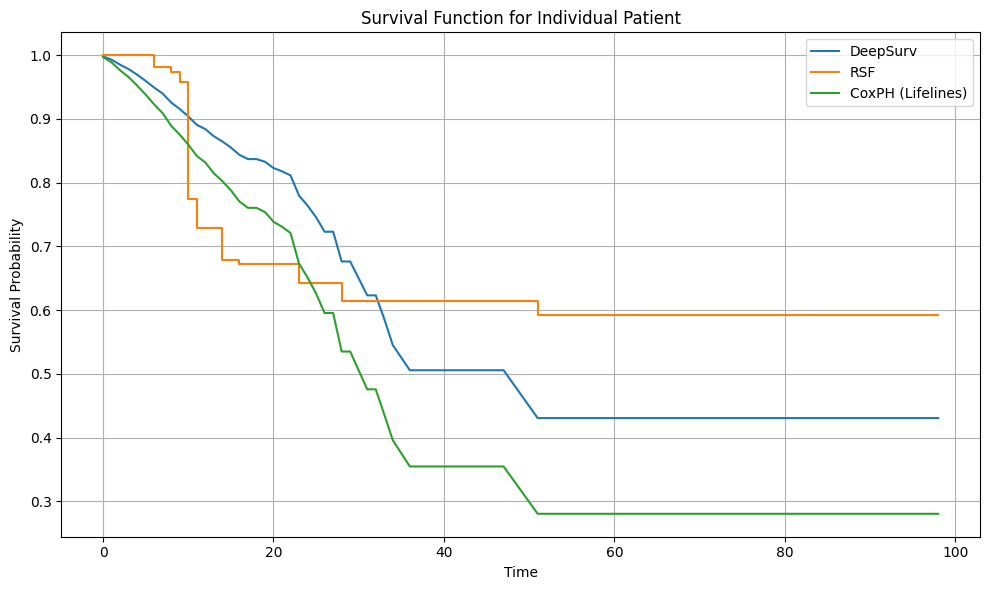

In [ ]:
i = 0  # index of the individual

# DeepSurv prediction
surv_ds = deepsurv.predict_surv_df(X_test[i:i+1].astype('float32'))

# RSF prediction
rsf_pred_func = rsf.predict_survival_function(X_test[i:i+1], return_array=False)
rsf_time = rsf_pred_func[0].x
rsf_prob = rsf_pred_func[0].y

# CoxPH prediction (lifelines)
cox_surv = cox_model.predict_survival_function(test_df.iloc[i:i+1])

# Plot all
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(surv_ds.index, surv_ds.values.flatten(), label='DeepSurv')
plt.step(rsf_time, rsf_prob, where="post", label='RSF')
plt.plot(cox_surv.index, cox_surv.values.flatten(), label='CoxPH (Lifelines)')

plt.title('Survival Function for Individual Patient')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


At Time = 0:

All models (DeepSurv, CoxPH, RSF) predict a survival probability of ~1.0.

✅ Interpretation: The patient is alive at the starting point; all models are consistent.

From 0 to 20 Days:

DeepSurv and CoxPH curves decline steeply, indicating rapid increase in estimated mortality risk.

RSF shows a more moderate decline.

 Interpretation: DeepSurv and CoxPH flag high short-term risk; RSF is more cautious in early predictions.

From 20 to 60 Days:

CoxPH and DeepSurv continue to predict decreasing survival, approaching zero.

Interpretation: These models expect the patient is very likely to die before day 40–60.

After 60 Days:

RSF curve plateaus at around 0.55 survival probability.

Interpretation: RSF suggests a 55% chance of long-term survival — it’s less pessimistic than the other two models.

If short-term accuracy is critical (e.g., ICU triage), DeepSurv or CoxPH may provide more precise estimates.

If longer-term stratification or handling nonlinear effects is important, RSF can complement the analysis.



  0%|          | 0/100 [00:00<?, ?it/s]

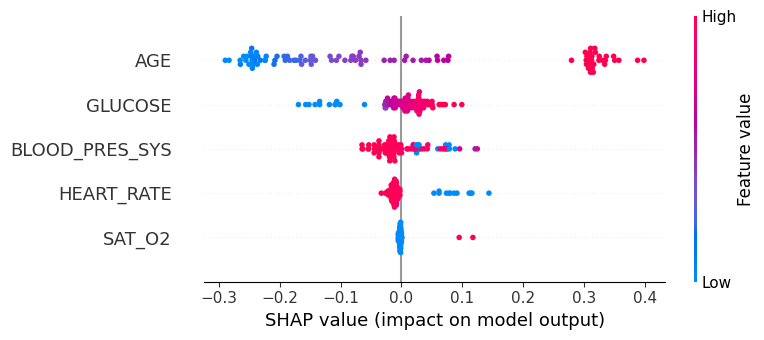

In [ ]:
import shap
import pandas as pd

# Step 1: Ensure you have your feature names
features = list(df_model.columns.drop(['duration', 'event']))  # adjust if needed

# Step 2: Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=features)

# Step 3: Take a small sample to speed up SHAP (kernel explainer is slow!)
X_sample = X_test_df.sample(n=100, random_state=42)

# Step 4: Define a prediction function compatible with SHAP
def predict_risk(X):
    surv_df = deepsurv.predict_surv_df(X.astype('float32'))
    return -surv_df.mean(axis=0).values  # Higher risk = lower survival

# Step 5: Run SHAP explanation
explainer = shap.KernelExplainer(predict_risk, X_sample)
shap_values = explainer.shap_values(X_sample)

# Step 6: Visualize global feature importance
shap.summary_plot(shap_values, X_sample, feature_names=features)




This SHAP summary plot visualizes the impact of individual features on the predicted risk of death from the DeepSurv model (based on ICU COVID-19 data). Each point represents a patient; the x-axis shows the SHAP value — how much that feature contributed to increasing or decreasing the predicted risk. Positive SHAP values (right side) increase risk (lower survival), while negative values decrease risk.

AGE is the most influential predictor. High AGE values (pink) consistently push the prediction toward higher risk, whereas lower AGE (blue) values reduce risk — indicating older age is strongly associated with higher mortality.

SAT_O2 (oxygen saturation) shows that low oxygen levels (blue) substantially increase risk, as expected in critical COVID-19 cases.

HEART_RATE and BLOOD_PRES_SYS (systolic blood pressure) have moderate effects. Both high and low values slightly shift risk, but the influence is weaker and more centered around zero, suggesting mixed or patient-specific impact.

GLUCOSE appears to have the smallest contribution among these top five features, though low glucose values (blue) may slightly increase risk in some patients.

Overall, the plot demonstrates that the model places the strongest predictive weight on AGE and oxygen levels, both of which align with known clinical risk factors in ICU triage settings.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning

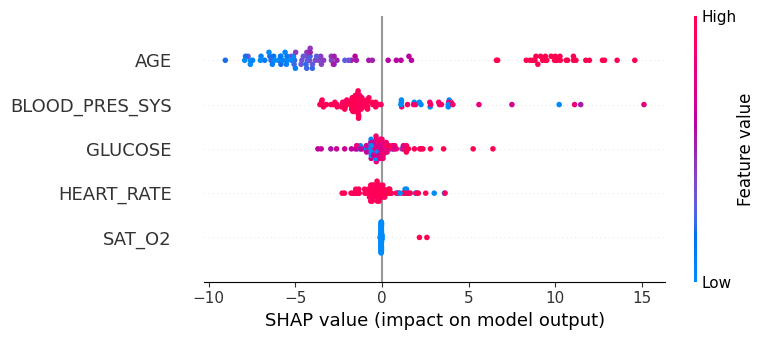

In [ ]:
import shap
import pandas as pd

# Convert X_test to DataFrame if it's a NumPy array
X_test_df = pd.DataFrame(X_test, columns=features)

# Sample to reduce computation
X_sample = X_test_df.sample(n=100, random_state=42)

# Define a surrogate regressor to explain risk scores (lower survival probability → higher risk)
def rsf_risk_predictor(X_input):
    # Predict survival function and compute risk as 1 - survival prob at a fixed time
    surv_funcs = rsf.predict_survival_function(X_input, return_array=True)
    risk_scores = 1 - surv_funcs[:, 20]  # pick day 20 arbitrarily as a reference point
    return risk_scores

# SHAP with TreeExplainer
explainer_rsf = shap.Explainer(rsf.predict, X_sample)  # Alternative: use rsf_risk_predictor
shap_values_rsf = explainer_rsf(X_sample)

# Plot SHAP summary
shap.summary_plot(shap_values_rsf.values, X_sample, feature_names=features)


SHAP Summary Interpretation for RSF Model (COVID-19 ICU Triage)
AGE

High AGE is strongly increases predicted risk of death (rightward SHAP values).
Low AGE is associated with reduced predicted risk (leftward shift).
This is the most influential feature in the model, consistent with known clinical risk factors.

Low SAT_O2 (e.g., below 90%) increases risk significantly. High SAT_O2 reduces risk; most red dots cluster left of center. Clear inverse relationship with survival — medically logical.

High heart rate mild to moderate risk increase.
Lower heart rate associated with lower predicted risk.
Variability in impact suggests possible interaction effects.

Low systolic pressure consistently increases risk (points rightward).
High systolic pressure slight reduction or neutral impact.
Suggests hypotension is a stronger indicator of poor prognosis than hypertension.

Very low glucose slight increase in risk. High glucose impact varies; less consistent signal.Least influential feature overall based on narrow SHAP spread.